# Deteccion de intencion con Naive_Bayes 

## Librerias

Archivos python para desglosar las funciones, y atacar el problema de forma modular. Puedes investigar cada unos de los archivos y sus funciones.

In [1]:
import preprocesamiento
import tf_idf
import optuna_objetive
import load_data

Resto de librerias que vamos a usar

In [ ]:
# pip install pandas matplotlib numpy seaborn wordcloud scikit-learn optuna

In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import string
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import time
from sklearn.naive_bayes import MultinomialNB
import optuna
from sklearn.metrics import accuracy_score

## Carga de datos

In [2]:
train_df, val_df, test_df = load_data.cargar_datos()

In [3]:
print(train_df.shape, val_df.shape, test_df.shape)
print(train_df.head())

(439361, 5) (54835, 5) (58625, 5)
                                                text labels  labels_str  \
0  also I was the point person on my companys tr...    [4]   [Neutral]   
1                   You mustve had your hands full.    [4]   [Neutral]   
2                            That I did. That I did.    [4]   [Neutral]   
3      So lets talk a little bit about your duties.    [4]   [Neutral]   
4                             My duties?  All right.    [6]  [Surprise]   

  labels_str_unif  labels_unif  
0         Neutral            4  
1         Neutral            4  
2         Neutral            4  
3         Neutral            4  
4        Surprise            6  


C:\Users\pablo\AppData\Local\Temp\ipykernel_6928\926810194.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x='labels_str_unif', palette='Set2')


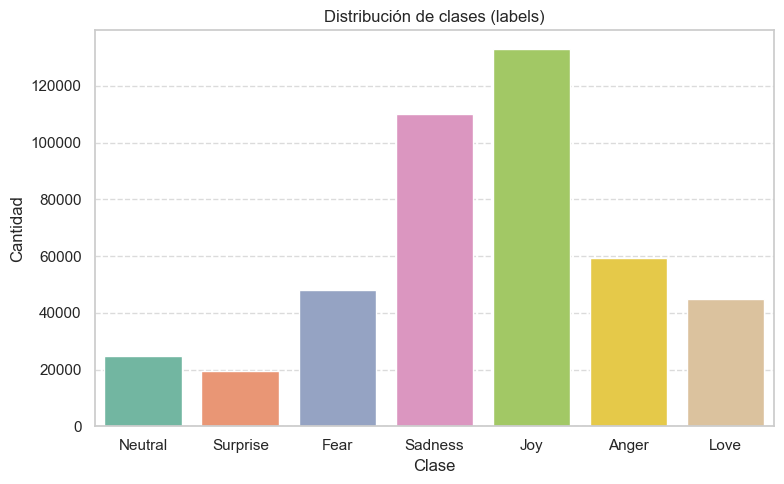

In [32]:
plt.figure(figsize=(8, 5))
sns.countplot(data=train_df, x='labels_str_unif', palette='Set2')

plt.title('Distribución de clases (labels)')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Preprocesamiento global

Quita minusculas, puntuacion, espacios.

In [4]:
df_train = preprocesamiento.preprocesar_df(train_df, 'text', 'text_proc')

df_test = preprocesamiento.preprocesar_df(test_df, 'text', 'text_proc')

## Variable objetivo

In [7]:
y_train = df_train['labels_str_unif'].values
y_test = df_test['labels_str_unif'].values

# Verificamos las categorías presentes en el conjunto de entrenamiento
categorias_unicas = np.unique(y_train)
print(f"Categorías en el conjunto de entrenamiento: {categorias_unicas}")

Categorías en el conjunto de entrenamiento: ['Anger' 'Fear' 'Joy' 'Love' 'Neutral' 'Sadness' 'Surprise']


## Optuna TPE para Naive-Bayes con TF-IDF

Para entrenar nuestro modelo debemos convertir cada texto en un vector numérico que pueda tratar Naive Bayes. Este proceso de vectorizacion se basa en asignar a cada palabra de nuestro vocabulario una posicion del vector y asignarle a esa posición el valor numérico según las veces que aparezca en cada texto.

Esto sería lo sencillo de explicar, el problema viene al responder estas preguntas:
    - Como de grande es nuestro vocabulario? Afecta al tiempo de computacion? A la precision del modelo?
    - Que pasara con las palabras nuevas? Durante el entrenamiento a cada palabra se le asigna una probabilidad de pertenecer a un grupo en la clasificacion, si esta palabra no aparece se le asignara 0. Se puede evitar?
    - Podria eliminar algunas palabras que aparecen en casi todos los textos? Y las que aparecen en solo unos pocos?
    - Y aun sabiendo todo esto, como podria probar la combinacion de estos hiperparametros?



### Ejecucion de Optuna, yo lo tengo guardado en .csv

**Puedes modificar variable = 'mean', 'train', 'test', según cual quieras optimizar, yo he optado en este ejemplo por la 'mean'**

Este es el esquema de resultados_trials, esto guarda para cada combinacion de parametros:

            'trial_number': trial.number,
            'alpha': alpha,
            'min_df': min_df,
            'max_df': max_df,
            'norm': norm,
            'use_idf': use_idf,
            'smooth_idf': smooth_idf,
            'sublinear_tf': sublinear_tf,
            'size': vocabulario,
            'accuracy_train': acc_train,
            'accuracy_test': acc_test,
            'accuracy_mean': mean_acc,

In [13]:
resultados_trials = []  # Guarda resultados de todas las pruebas
study = optuna.create_study(direction="maximize") 
study.optimize(lambda trial: optuna_objetive.objective(trial, df_train, df_test, y_train, y_test, resultados_trials, variable = 'mean'), n_trials=30)


[I 2025-07-16 19:52:35,983] A new study created in memory with name: no-name-fdcbea26-b2ef-4435-af7f-43e6356b5704
C:\Users\pablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 4000] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 3951].
  warnings.warn(


- Tamaño del vocabulario: 495 términos
- Dimensiones matriz train: (439361, 495)
- Dimensiones matriz test: (58625, 495)
- Densidad matriz train: 0.01953


[I 2025-07-16 19:52:46,239] Trial 0 finished with value: 0.45111251593823437 and parameters: {'min_df': 1551, 'max_df': 0.37763669253584153, 'norm': None, 'use_idf': False, 'smooth_idf': True, 'sublinear_tf': False, 'alpha': 0.013148839583792647}. Best is trial 0 with value: 0.45111251593823437.
C:\Users\pablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 4000] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 3951].
  warnings.warn(


- Tamaño del vocabulario: 274 términos
- Dimensiones matriz train: (439361, 274)
- Dimensiones matriz test: (58625, 274)
- Densidad matriz train: 0.03476


[I 2025-07-16 19:52:53,225] Trial 1 finished with value: 0.363644468222165 and parameters: {'min_df': 2901, 'max_df': 0.5677052761479395, 'norm': 'l2', 'use_idf': True, 'smooth_idf': False, 'sublinear_tf': False, 'alpha': 0.270558220662996}. Best is trial 0 with value: 0.45111251593823437.
C:\Users\pablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 4000] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 3951].
  warnings.warn(


- Tamaño del vocabulario: 334 términos
- Dimensiones matriz train: (439361, 334)
- Dimensiones matriz test: (58625, 334)
- Densidad matriz train: 0.01895


[I 2025-07-16 19:53:00,808] Trial 2 finished with value: 0.38476385235353594 and parameters: {'min_df': 2251, 'max_df': 0.11861366588995093, 'norm': 'l2', 'use_idf': True, 'smooth_idf': True, 'sublinear_tf': True, 'alpha': 0.550627441147319}. Best is trial 0 with value: 0.45111251593823437.
C:\Users\pablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 4000] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 3951].
  warnings.warn(


- Tamaño del vocabulario: 1050 términos
- Dimensiones matriz train: (439361, 1050)
- Dimensiones matriz test: (58625, 1050)
- Densidad matriz train: 0.01135


[I 2025-07-16 19:53:08,869] Trial 3 finished with value: 0.46508250954821195 and parameters: {'min_df': 701, 'max_df': 0.8895721755335725, 'norm': 'l1', 'use_idf': False, 'smooth_idf': True, 'sublinear_tf': True, 'alpha': 2.9263821921144846}. Best is trial 3 with value: 0.46508250954821195.
C:\Users\pablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 4000] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 3951].
  warnings.warn(


- Tamaño del vocabulario: 222 términos
- Dimensiones matriz train: (439361, 222)
- Dimensiones matriz test: (58625, 222)
- Densidad matriz train: 0.02390


[I 2025-07-16 19:53:16,563] Trial 4 finished with value: 0.302534541768546 and parameters: {'min_df': 3351, 'max_df': 0.10704571036503889, 'norm': None, 'use_idf': True, 'smooth_idf': True, 'sublinear_tf': False, 'alpha': 2.8527595894240485}. Best is trial 3 with value: 0.46508250954821195.
C:\Users\pablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 4000] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 3951].
  warnings.warn(


- Tamaño del vocabulario: 1825 términos
- Dimensiones matriz train: (439361, 1825)
- Dimensiones matriz test: (58625, 1825)
- Densidad matriz train: 0.00697


[I 2025-07-16 19:53:24,331] Trial 5 finished with value: 0.745764866343086 and parameters: {'min_df': 301, 'max_df': 0.950036663854393, 'norm': None, 'use_idf': True, 'smooth_idf': True, 'sublinear_tf': False, 'alpha': 1.3086244131840339}. Best is trial 5 with value: 0.745764866343086.
C:\Users\pablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 4000] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 3951].
  warnings.warn(


- Tamaño del vocabulario: 1237 términos
- Dimensiones matriz train: (439361, 1237)
- Dimensiones matriz test: (58625, 1237)
- Densidad matriz train: 0.00854


[I 2025-07-16 19:53:31,884] Trial 6 finished with value: 0.6663713227761878 and parameters: {'min_df': 551, 'max_df': 0.2542076586828891, 'norm': 'l2', 'use_idf': False, 'smooth_idf': False, 'sublinear_tf': False, 'alpha': 1.0573054583144916}. Best is trial 5 with value: 0.745764866343086.
C:\Users\pablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 4000] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 3951].
  warnings.warn(


- Tamaño del vocabulario: 268 términos
- Dimensiones matriz train: (439361, 268)
- Dimensiones matriz test: (58625, 268)
- Densidad matriz train: 0.03539


[I 2025-07-16 19:53:39,440] Trial 7 finished with value: 0.33811474398982877 and parameters: {'min_df': 2951, 'max_df': 0.7269238930662124, 'norm': None, 'use_idf': True, 'smooth_idf': False, 'sublinear_tf': True, 'alpha': 0.07219580264894478}. Best is trial 5 with value: 0.745764866343086.
C:\Users\pablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 4000] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 3951].
  warnings.warn(


- Tamaño del vocabulario: 484 términos
- Dimensiones matriz train: (439361, 484)
- Dimensiones matriz test: (58625, 484)
- Densidad matriz train: 0.02176


[I 2025-07-16 19:53:47,269] Trial 8 finished with value: 0.4353955179403327 and parameters: {'min_df': 1601, 'max_df': 0.7682944505918996, 'norm': None, 'use_idf': True, 'smooth_idf': True, 'sublinear_tf': True, 'alpha': 0.017170191236221773}. Best is trial 5 with value: 0.745764866343086.
C:\Users\pablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 4000] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 3951].
  warnings.warn(


- Tamaño del vocabulario: 323 términos
- Dimensiones matriz train: (439361, 323)
- Dimensiones matriz test: (58625, 323)
- Densidad matriz train: 0.03041


[I 2025-07-16 19:53:54,870] Trial 9 finished with value: 0.3679806928951077 and parameters: {'min_df': 2451, 'max_df': 0.6819109353521416, 'norm': 'l2', 'use_idf': False, 'smooth_idf': True, 'sublinear_tf': False, 'alpha': 2.1360204385279484}. Best is trial 5 with value: 0.745764866343086.
C:\Users\pablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 4000] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 3951].
  warnings.warn(


- Tamaño del vocabulario: 1825 términos
- Dimensiones matriz train: (439361, 1825)
- Dimensiones matriz test: (58625, 1825)
- Densidad matriz train: 0.00697


[I 2025-07-16 19:54:02,433] Trial 10 finished with value: 0.5639233264471131 and parameters: {'min_df': 301, 'max_df': 0.9501462108319991, 'norm': 'l1', 'use_idf': True, 'smooth_idf': False, 'sublinear_tf': False, 'alpha': 0.11089632351273614}. Best is trial 5 with value: 0.745764866343086.
C:\Users\pablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 4000] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 3951].
  warnings.warn(


- Tamaño del vocabulario: 906 términos
- Dimensiones matriz train: (439361, 906)
- Dimensiones matriz test: (58625, 906)
- Densidad matriz train: 0.01110


[I 2025-07-16 19:54:10,239] Trial 11 finished with value: 0.6434155809598441 and parameters: {'min_df': 851, 'max_df': 0.31181229890339524, 'norm': 'l2', 'use_idf': False, 'smooth_idf': False, 'sublinear_tf': False, 'alpha': 0.8113910124567046}. Best is trial 5 with value: 0.745764866343086.
C:\Users\pablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 4000] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 3951].
  warnings.warn(


- Tamaño del vocabulario: 108197 términos
- Dimensiones matriz train: (439361, 108197)
- Dimensiones matriz test: (58625, 108197)
- Densidad matriz train: 0.00013


[I 2025-07-16 19:54:17,719] Trial 12 finished with value: 0.7530842642383886 and parameters: {'min_df': 1, 'max_df': 0.4099966279654762, 'norm': None, 'use_idf': False, 'smooth_idf': False, 'sublinear_tf': False, 'alpha': 1.0559177084683693}. Best is trial 12 with value: 0.7530842642383886.
C:\Users\pablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 4000] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 3951].
  warnings.warn(


- Tamaño del vocabulario: 5783 términos
- Dimensiones matriz train: (439361, 5783)
- Dimensiones matriz test: (58625, 5783)
- Densidad matriz train: 0.00230


[I 2025-07-16 19:54:25,432] Trial 13 finished with value: 0.7583897070250438 and parameters: {'min_df': 51, 'max_df': 0.4948711306841027, 'norm': None, 'use_idf': False, 'smooth_idf': False, 'sublinear_tf': False, 'alpha': 0.34670114393042284}. Best is trial 13 with value: 0.7583897070250438.
C:\Users\pablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 4000] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 3951].
  warnings.warn(


- Tamaño del vocabulario: 5783 términos
- Dimensiones matriz train: (439361, 5783)
- Dimensiones matriz test: (58625, 5783)
- Densidad matriz train: 0.00230


[I 2025-07-16 19:54:32,941] Trial 14 finished with value: 0.7583777768672568 and parameters: {'min_df': 51, 'max_df': 0.46619404545890936, 'norm': None, 'use_idf': False, 'smooth_idf': False, 'sublinear_tf': False, 'alpha': 0.3180287711652034}. Best is trial 13 with value: 0.7583897070250438.
C:\Users\pablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 4000] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 3951].
  warnings.warn(


- Tamaño del vocabulario: 673 términos
- Dimensiones matriz train: (439361, 673)
- Dimensiones matriz test: (58625, 673)
- Densidad matriz train: 0.01574


[I 2025-07-16 19:54:39,953] Trial 15 finished with value: 0.5860707344081484 and parameters: {'min_df': 1201, 'max_df': 0.5222450098445797, 'norm': None, 'use_idf': False, 'smooth_idf': False, 'sublinear_tf': False, 'alpha': 0.28513792640246444}. Best is trial 13 with value: 0.7583897070250438.
C:\Users\pablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 4000] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 3951].
  warnings.warn(


- Tamaño del vocabulario: 108198 términos
- Dimensiones matriz train: (439361, 108198)
- Dimensiones matriz test: (58625, 108198)
- Densidad matriz train: 0.00014


[I 2025-07-16 19:54:47,660] Trial 16 finished with value: 0.5060218208835161 and parameters: {'min_df': 1, 'max_df': 0.5337021588332005, 'norm': 'l1', 'use_idf': False, 'smooth_idf': False, 'sublinear_tf': False, 'alpha': 0.04614274548802564}. Best is trial 13 with value: 0.7583897070250438.
C:\Users\pablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 4000] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 3951].
  warnings.warn(


- Tamaño del vocabulario: 713 términos
- Dimensiones matriz train: (439361, 713)
- Dimensiones matriz test: (58625, 713)
- Densidad matriz train: 0.01501


[I 2025-07-16 19:54:55,429] Trial 17 finished with value: 0.6146975863265352 and parameters: {'min_df': 1151, 'max_df': 0.44402889431058334, 'norm': None, 'use_idf': False, 'smooth_idf': False, 'sublinear_tf': False, 'alpha': 0.1637221479736366}. Best is trial 13 with value: 0.7583897070250438.
C:\Users\pablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 4000] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 3951].
  warnings.warn(


- Tamaño del vocabulario: 419 términos
- Dimensiones matriz train: (439361, 419)
- Dimensiones matriz test: (58625, 419)
- Densidad matriz train: 0.02454


[I 2025-07-16 19:55:02,629] Trial 18 finished with value: 0.4320947057494706 and parameters: {'min_df': 1851, 'max_df': 0.6446302894735233, 'norm': None, 'use_idf': False, 'smooth_idf': False, 'sublinear_tf': True, 'alpha': 0.449519550121194}. Best is trial 13 with value: 0.7583897070250438.
C:\Users\pablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 4000] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 3951].
  warnings.warn(


- Tamaño del vocabulario: 212 términos
- Dimensiones matriz train: (439361, 212)
- Dimensiones matriz test: (58625, 212)
- Densidad matriz train: 0.03404


[I 2025-07-16 19:55:10,331] Trial 19 finished with value: 0.339536372179273 and parameters: {'min_df': 3851, 'max_df': 0.2398949412904952, 'norm': None, 'use_idf': False, 'smooth_idf': False, 'sublinear_tf': False, 'alpha': 0.040284197371985846}. Best is trial 13 with value: 0.7583897070250438.
C:\Users\pablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 4000] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 3951].
  warnings.warn(


- Tamaño del vocabulario: 674 términos
- Dimensiones matriz train: (439361, 674)
- Dimensiones matriz test: (58625, 674)
- Densidad matriz train: 0.01650


[I 2025-07-16 19:55:17,734] Trial 20 finished with value: 0.416500950835709 and parameters: {'min_df': 1201, 'max_df': 0.8176841361128497, 'norm': 'l1', 'use_idf': False, 'smooth_idf': False, 'sublinear_tf': False, 'alpha': 0.14127750585097226}. Best is trial 13 with value: 0.7583897070250438.
C:\Users\pablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 4000] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 3951].
  warnings.warn(


- Tamaño del vocabulario: 3749 términos
- Dimensiones matriz train: (439361, 3749)
- Dimensiones matriz test: (58625, 3749)
- Densidad matriz train: 0.00345


[I 2025-07-16 19:55:25,189] Trial 21 finished with value: 0.7542906003115816 and parameters: {'min_df': 101, 'max_df': 0.43243446539160457, 'norm': None, 'use_idf': False, 'smooth_idf': False, 'sublinear_tf': False, 'alpha': 4.8053397422772886}. Best is trial 13 with value: 0.7583897070250438.
C:\Users\pablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 4000] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 3951].
  warnings.warn(


- Tamaño del vocabulario: 1408 términos
- Dimensiones matriz train: (439361, 1408)
- Dimensiones matriz test: (58625, 1408)
- Densidad matriz train: 0.00842


[I 2025-07-16 19:55:32,952] Trial 22 finished with value: 0.7325814652641329 and parameters: {'min_df': 451, 'max_df': 0.46741577027479203, 'norm': None, 'use_idf': False, 'smooth_idf': False, 'sublinear_tf': False, 'alpha': 4.384159073708001}. Best is trial 13 with value: 0.7583897070250438.
C:\Users\pablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 4000] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 3951].
  warnings.warn(


- Tamaño del vocabulario: 5784 términos
- Dimensiones matriz train: (439361, 5784)
- Dimensiones matriz test: (58625, 5784)
- Densidad matriz train: 0.00239


[I 2025-07-16 19:55:40,423] Trial 23 finished with value: 0.7609378749208806 and parameters: {'min_df': 51, 'max_df': 0.6044323989569307, 'norm': None, 'use_idf': False, 'smooth_idf': False, 'sublinear_tf': False, 'alpha': 0.41519703478058506}. Best is trial 23 with value: 0.7609378749208806.
C:\Users\pablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 4000] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 3951].
  warnings.warn(


- Tamaño del vocabulario: 826 términos
- Dimensiones matriz train: (439361, 826)
- Dimensiones matriz test: (58625, 826)
- Densidad matriz train: 0.01392


[I 2025-07-16 19:55:47,860] Trial 24 finished with value: 0.6826541529256855 and parameters: {'min_df': 1001, 'max_df': 0.6088226167980909, 'norm': None, 'use_idf': False, 'smooth_idf': False, 'sublinear_tf': False, 'alpha': 0.48093679835596853}. Best is trial 23 with value: 0.7609378749208806.
C:\Users\pablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 4000] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 3951].
  warnings.warn(


- Tamaño del vocabulario: 1100 términos
- Dimensiones matriz train: (439361, 1100)
- Dimensiones matriz test: (58625, 1100)
- Densidad matriz train: 0.00975


[I 2025-07-16 19:55:55,710] Trial 25 finished with value: 0.7127790118183313 and parameters: {'min_df': 651, 'max_df': 0.3464690932246632, 'norm': None, 'use_idf': False, 'smooth_idf': False, 'sublinear_tf': False, 'alpha': 0.3023857294147778}. Best is trial 23 with value: 0.7609378749208806.
C:\Users\pablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 4000] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 3951].
  warnings.warn(


- Tamaño del vocabulario: 1312 términos
- Dimensiones matriz train: (439361, 1312)
- Dimensiones matriz test: (58625, 1312)
- Densidad matriz train: 0.00896


[I 2025-07-16 19:56:03,354] Trial 26 finished with value: 0.7331176406806224 and parameters: {'min_df': 501, 'max_df': 0.49935735811265236, 'norm': None, 'use_idf': False, 'smooth_idf': False, 'sublinear_tf': True, 'alpha': 0.1931725175121007}. Best is trial 23 with value: 0.7609378749208806.
C:\Users\pablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 4000] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 3951].
  warnings.warn(


- Tamaño del vocabulario: 2378 términos
- Dimensiones matriz train: (439361, 2378)
- Dimensiones matriz test: (58625, 2378)
- Densidad matriz train: 0.00548


[I 2025-07-16 19:56:10,927] Trial 27 finished with value: 0.7550963841949786 and parameters: {'min_df': 201, 'max_df': 0.6020395549210877, 'norm': None, 'use_idf': False, 'smooth_idf': False, 'sublinear_tf': False, 'alpha': 0.09534452952246389}. Best is trial 23 with value: 0.7609378749208806.
C:\Users\pablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 4000] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 3951].
  warnings.warn(


- Tamaño del vocabulario: 910 términos
- Dimensiones matriz train: (439361, 910)
- Dimensiones matriz test: (58625, 910)
- Densidad matriz train: 0.01283


[I 2025-07-16 19:56:19,022] Trial 28 finished with value: 0.47667416307717947 and parameters: {'min_df': 851, 'max_df': 0.721938102553563, 'norm': 'l1', 'use_idf': False, 'smooth_idf': False, 'sublinear_tf': False, 'alpha': 0.7025304406926981}. Best is trial 23 with value: 0.7609378749208806.
C:\Users\pablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 4000] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 3951].
  warnings.warn(


- Tamaño del vocabulario: 529 términos
- Dimensiones matriz train: (439361, 529)
- Dimensiones matriz test: (58625, 529)
- Densidad matriz train: 0.01781


[I 2025-07-16 19:56:26,477] Trial 29 finished with value: 0.4699396006438096 and parameters: {'min_df': 1451, 'max_df': 0.3628316443362605, 'norm': None, 'use_idf': False, 'smooth_idf': False, 'sublinear_tf': False, 'alpha': 0.4261734553049281}. Best is trial 23 with value: 0.7609378749208806.


## Graficas y resultados

### Cargar .CSV

Leemos nuestro csv que hemos guardado de nuestra realizacion de optuna con 300 iteraciones

In [35]:
ruta_csv = 'optuna_naive_bayes_trials_completo.csv'
if os.path.isfile(ruta_csv):
    df_resultados = pd.read_csv(ruta_csv)
    print(f"Cargado DataFrame desde {ruta_csv}")

Cargado DataFrame desde optuna_naive_bayes_trials_completo.csv


### Guardar el array como un .CSV

In [39]:
df_trials = pd.DataFrame(resultados_trials)
df_trials.to_csv("optuna_naive_bayes_trials_completo.csv", index=False)

### Grafica todas combinaciones 

Podemos observar en esta grafica todos las combinaciones que ha probado y como ha llegado a un accuracy_mean del 76% teniendo un claro sobreentrenamiento 83% en el dataset de entrenamiento y 70% en el test

     trial_number     alpha  min_df    max_df norm  use_idf  smooth_idf  \
275           225  3.301200       1  0.982252  NaN     True       False   
277           227  3.215157       1  0.961921  NaN     True       False   
273           223  2.714517       1  0.983981  NaN     True       False   
269           219  2.443520       1  0.985362  NaN     True       False   
271           221  1.963161       1  0.998018  NaN     True       False   

     sublinear_tf  accuracy_train  accuracy_test  accuracy_mean  
275          True        0.828062       0.705569       0.766815  
277          True        0.828264       0.705365       0.766814  
273          True        0.829254       0.702789       0.766022  
269          True        0.829837       0.700981       0.765409  
271          True        0.831209       0.697211       0.764210  


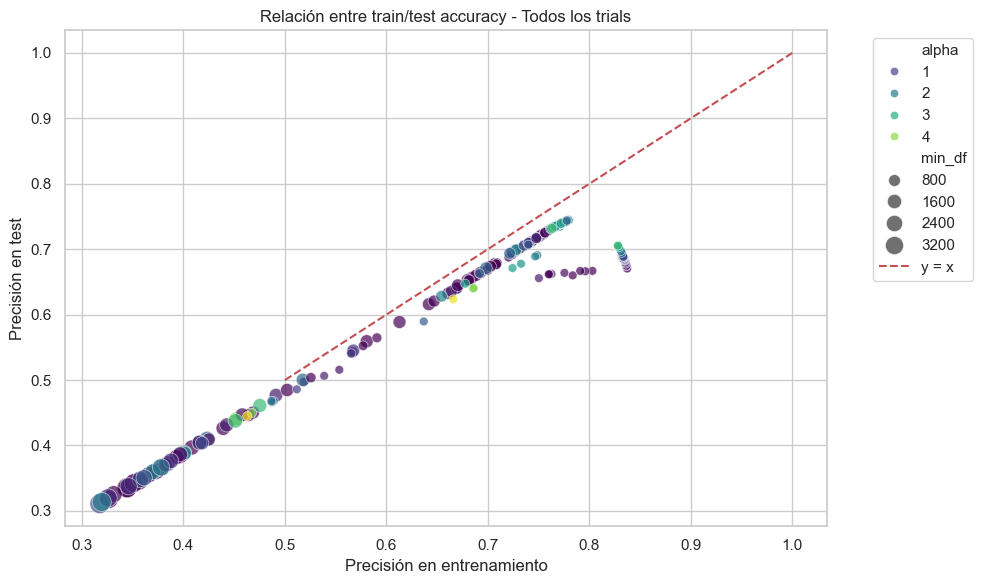

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Mostrar mejores combinaciones ordenadas por media
print(df_resultados.sort_values(by="accuracy_mean", ascending=False).head())

# 📈 Visualización
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_resultados,
    x='accuracy_train',
    y='accuracy_test',
    hue='alpha',
    palette='viridis',
    size='min_df',
    sizes=(40, 200),
    alpha=0.7
)
plt.plot([0.5, 1], [0.5, 1], 'r--', label='y = x')
plt.xlabel("Precisión en entrenamiento")
plt.ylabel("Precisión en test")
plt.title("Relación entre train/test accuracy - Todos los trials")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

    trial_number     alpha  min_df    max_df  norm  use_idf  smooth_idf  \
25            25  0.012105      41  0.806019  None    False       False   
43            43  0.002554      43  0.885349  None    False       False   
41            41  0.002995      43  0.828786  None    False       False   
47            47  0.003169      43  0.829021  None    False       False   
44            44  0.002746      43  0.885069  None    False       False   

    sublinear_tf  accuracy_train  accuracy_test  accuracy_mean  
25          True        0.782065       0.745399       0.763732  
43          True        0.781911       0.745450       0.763680  
41          True        0.781911       0.745450       0.763680  
47          True        0.781911       0.745450       0.763680  
44          True        0.781911       0.745450       0.763680  


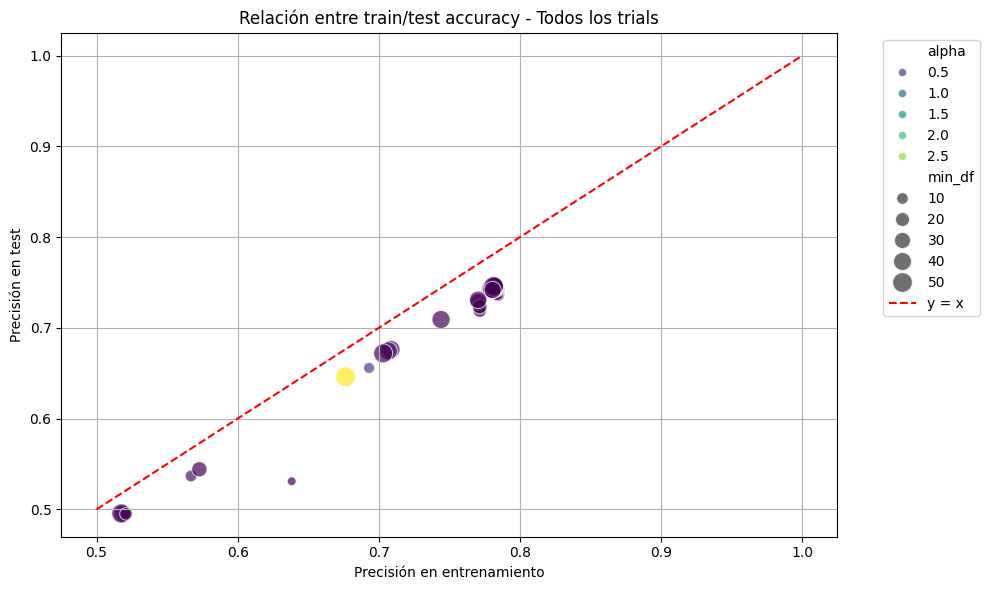

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convertir resultados a DataFrame
df_trials = pd.DataFrame(resultados_trials)

# Mostrar mejores combinaciones ordenadas por media
print(df_trials.sort_values(by="accuracy_mean", ascending=False).head())

# 📈 Visualización
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_trials,
    x='accuracy_train',
    y='accuracy_test',
    hue='alpha',
    palette='viridis',
    size='min_df',
    sizes=(40, 200),
    alpha=0.7
)
plt.plot([0.5, 1], [0.5, 1], 'r--', label='y = x')
plt.xlabel("Precisión en entrenamiento")
plt.ylabel("Precisión en test")
plt.title("Relación entre train/test accuracy - Todos los trials")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

### Grafica de accuracy_test con cada parametro 

- **Alpha**: Sin mucha variación se obtiene buen rendimiento en todo el espectro.
- **min_df**: Se obtienen mejores resultados cuando es más bajo, sin llegar a 1.  
  Al menos nos conviene quitar palabras muy raras.
- **max_df**: Se logran buenos resultados desde 0.5.  
  Nos llama la atención el buen rendimiento con 0.2, por lo que puede ser un parámetro a estudiar para reducir considerablemente el tamaño del vocabulario.
- **norm**: La norma cuadrática **L2** mejora considerablemente el rendimiento.

---

 **Observación adicional:**  
La matriz de covarianzas revela una correlación negativa fuerte (**-0.85**) respecto a `min_df`, lo cual indica cuánto impacta este parámetro en la reducción del vocabulario.  
Esto podría estar también influenciado por el **desbalance de clases**, ya que la mayoría de los textos pertenecen a la clase `'Joy'`.

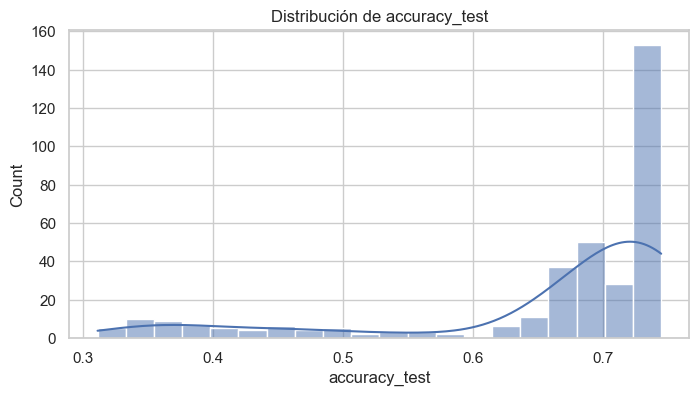

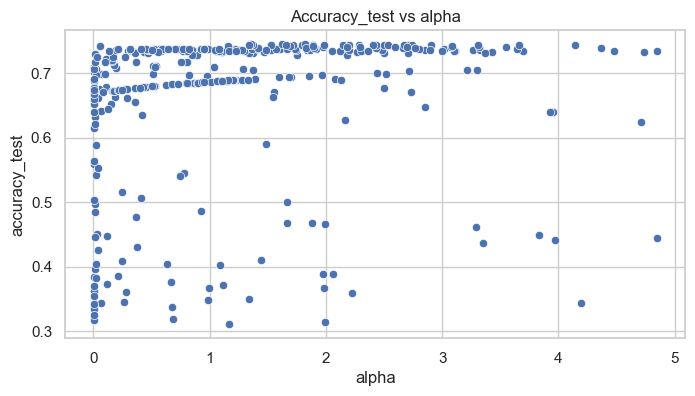

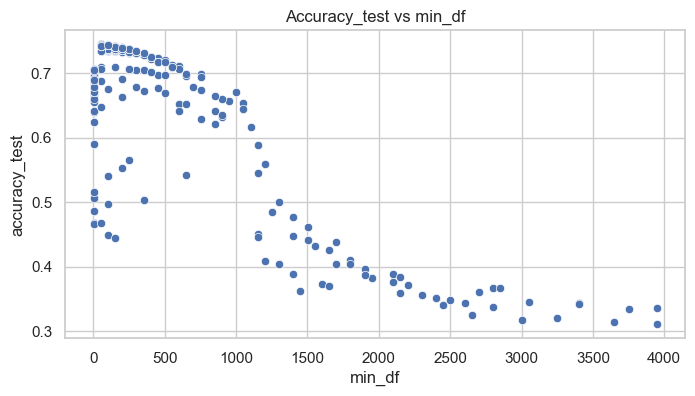

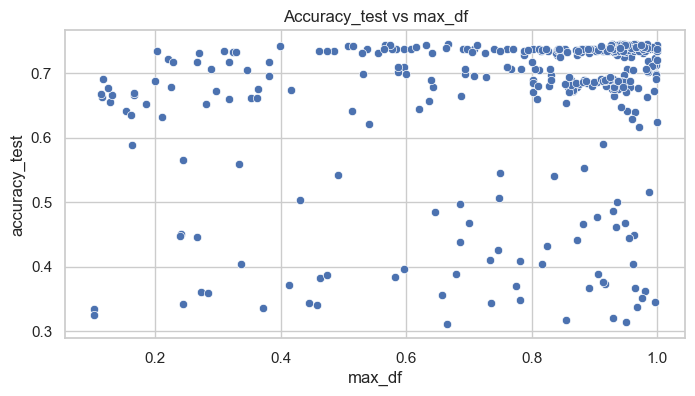

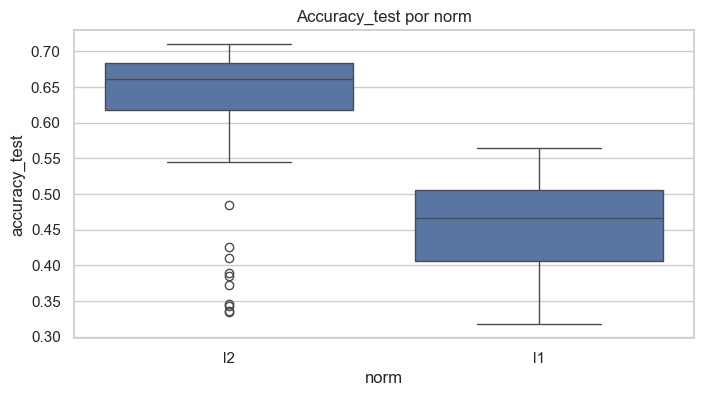

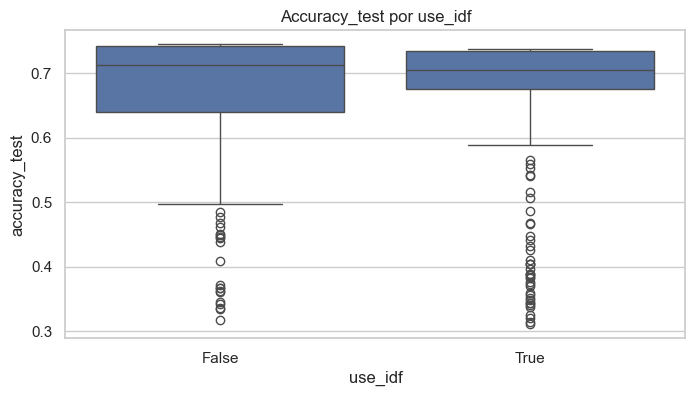

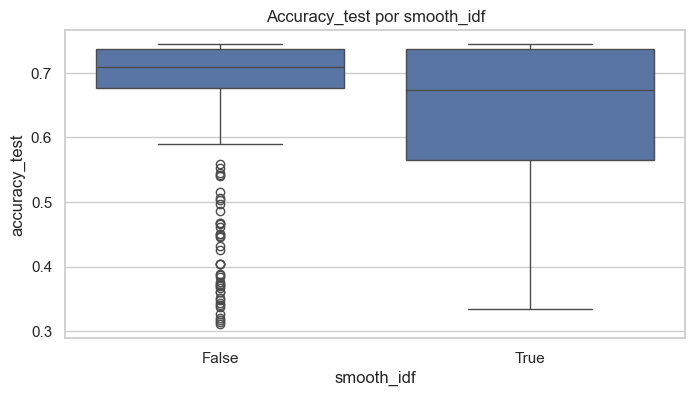

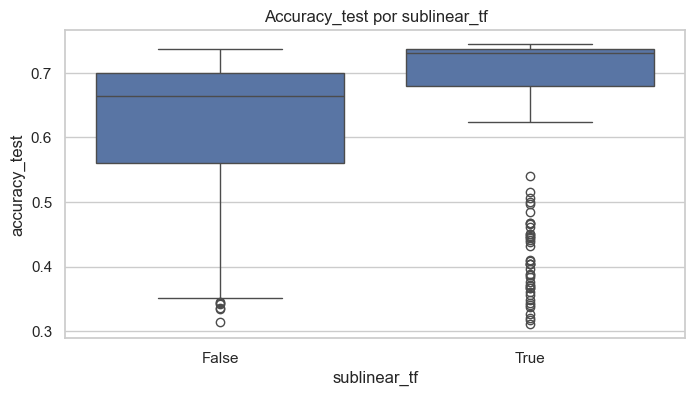

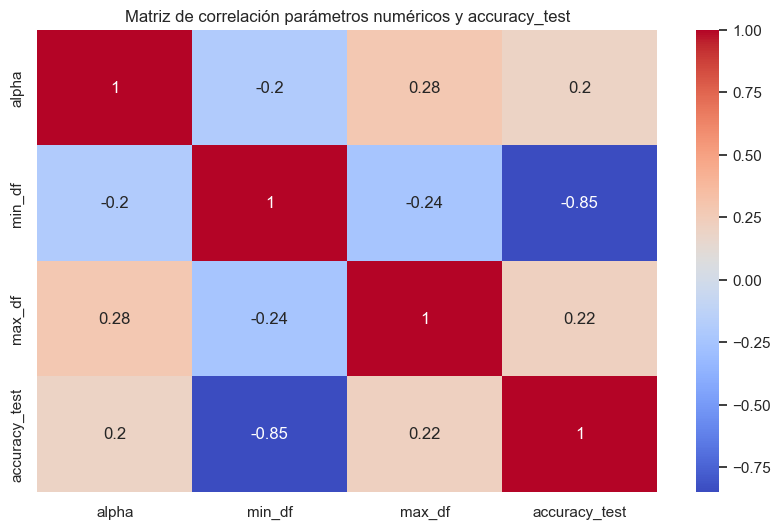

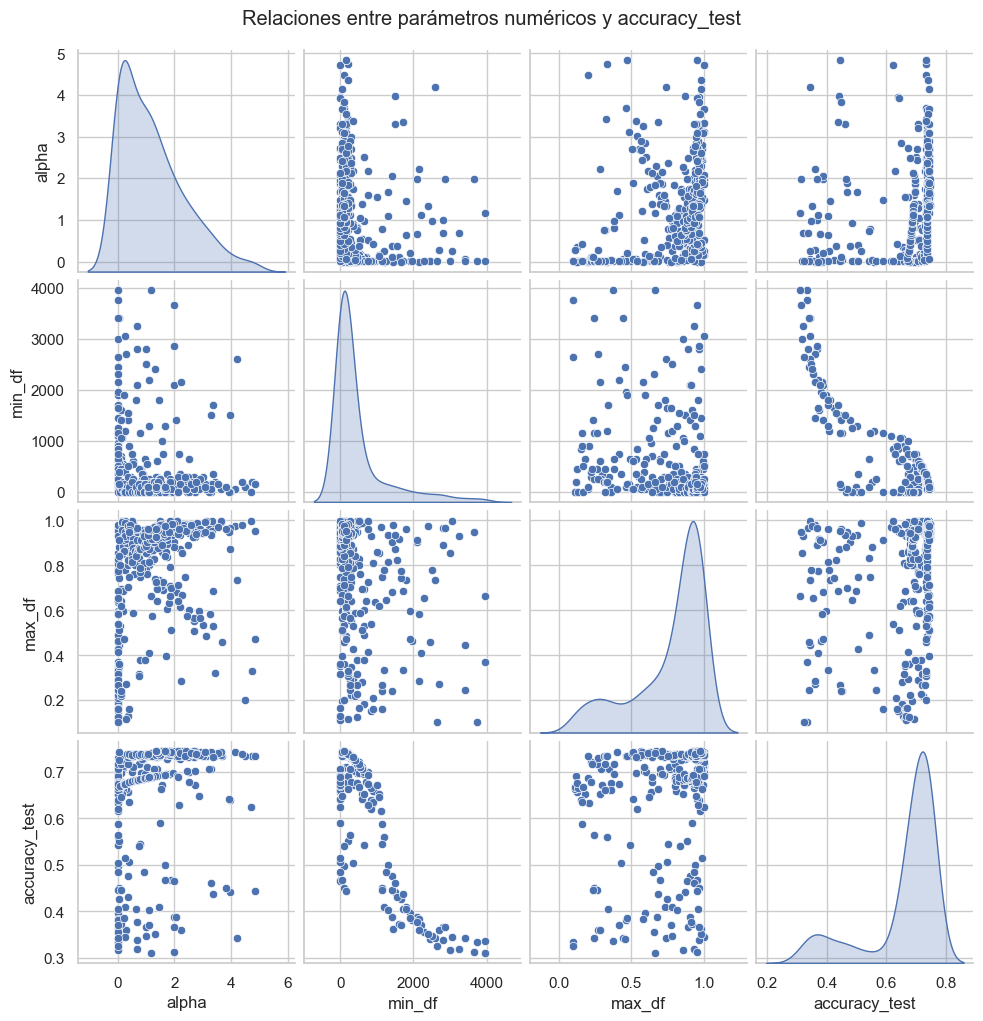

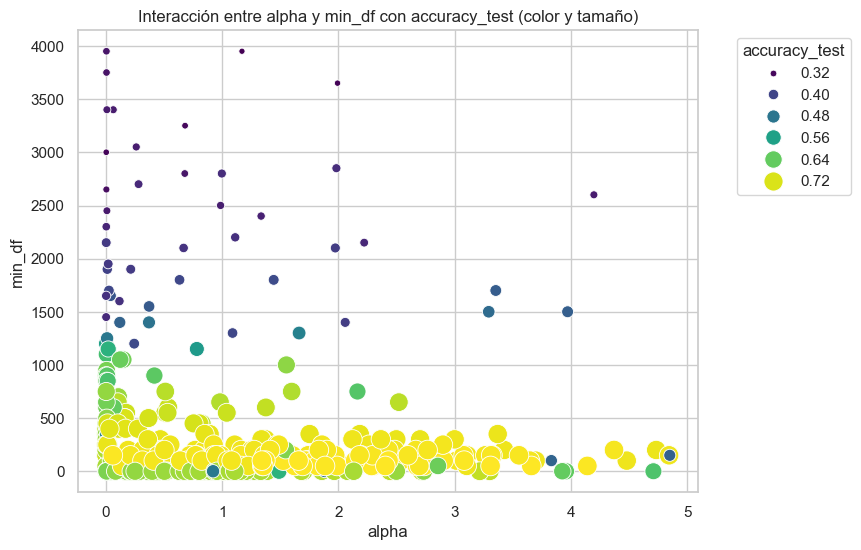

In [17]:
# Ajustes generales para seaborn
sns.set(style="whitegrid")

# 1. Distribución de accuracy_test general
plt.figure(figsize=(8,4))
sns.histplot(df_resultados['accuracy_test'], bins=20, kde=True)
plt.title('Distribución de accuracy_test')
plt.xlabel('accuracy_test')
plt.show()

# 2. Scatter plots para parámetros numéricos vs accuracy_test

parametros_numericos = ['alpha', 'min_df', 'max_df']

for param in parametros_numericos:
    plt.figure(figsize=(8,4))
    sns.scatterplot(data=df_resultados, x=param, y='accuracy_test')
    plt.title(f'Accuracy_test vs {param}')
    plt.xlabel(param)
    plt.ylabel('accuracy_test')
    plt.show()

# 3. Boxplots para parámetros categóricos vs accuracy_test

parametros_categoricos = ['norm', 'use_idf', 'smooth_idf', 'sublinear_tf']

for param in parametros_categoricos:
    plt.figure(figsize=(8,4))
    sns.boxplot(data=df_resultados, x=param, y='accuracy_test')
    plt.title(f'Accuracy_test por {param}')
    plt.xlabel(param)
    plt.ylabel('accuracy_test')
    plt.show()

# 4. Correlación entre parámetros numéricos y accuracy_test

plt.figure(figsize=(10,6))
corr = df_resultados[parametros_numericos + ['accuracy_test']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Matriz de correlación parámetros numéricos y accuracy_test')
plt.show()

# 5. Gráfico de pares (pairplot) para ver relaciones cruzadas

sns.pairplot(df_resultados, vars=parametros_numericos + ['accuracy_test'], kind='scatter', diag_kind='kde')
plt.suptitle('Relaciones entre parámetros numéricos y accuracy_test', y=1.02)
plt.show()

# 6. Visualización avanzada: gráficas de interacción (contour) para dos parámetros numéricos

import numpy as np

# Elegimos dos parámetros para visualizar interacción, por ejemplo alpha y min_df
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_resultados, x='alpha', y='min_df', hue='accuracy_test', palette='viridis', size='accuracy_test', sizes=(20,200), legend='brief')
plt.title('Interacción entre alpha y min_df con accuracy_test (color y tamaño)')
plt.xlabel('alpha')
plt.ylabel('min_df')
plt.legend(title='accuracy_test', bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

### Evolucion de accuracy_mean 

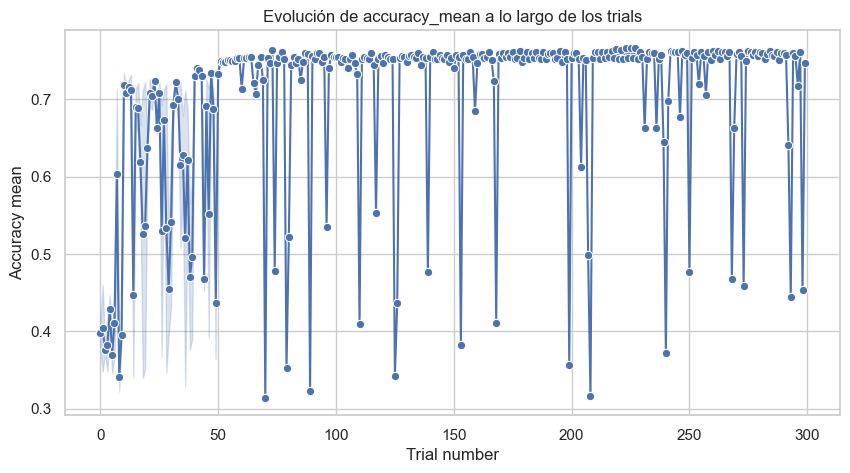

In [40]:
plt.figure(figsize=(10,5))
sns.lineplot(data=df_resultados, x='trial_number', y='accuracy_mean', marker='o')
plt.title('Evolución de accuracy_mean a lo largo de los trials')
plt.xlabel('Trial number')
plt.ylabel('Accuracy mean')
plt.grid(True)
plt.show()

### Accuracy_test

Mostrar que ha ido mejorando gracias a Optuna a ido encontrando la mejor combinacion de parametros

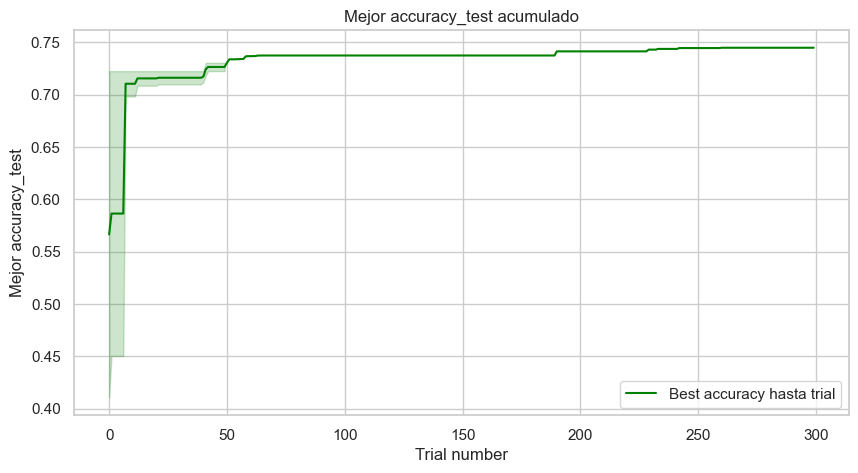

In [41]:
df_resultados['best_so_far'] = df_resultados['accuracy_test'].cummax()

plt.figure(figsize=(10,5))
sns.lineplot(data=df_resultados, x='trial_number', y='best_so_far', label='Best accuracy hasta trial', color='green')
plt.title('Mejor accuracy_test acumulado')
plt.xlabel('Trial number')
plt.ylabel('Mejor accuracy_test')
plt.grid(True)
plt.show()


### Parametros que han mejorado el accuracy_test en cada iteracion

In [23]:
def detectar_mejoras(df):
    # Ordenar por trial si no está ya
    df = df.sort_values('trial_number').reset_index(drop=True)
    
    # Calcular la mejor accuracy_test acumulada hasta cada punto
    df['best_so_far'] = df['accuracy_test'].cummax()
    
    # Marcar en qué trials se mejora el accuracy_test
    mejoras = df['accuracy_test'] > df['best_so_far'].shift(1).fillna(0)
    df['mejora'] = mejoras

    return df
def comparar_cambios(df, param_cols):
    cambios = []
    last_best_params = None
    
    for idx, row in df.iterrows():
        if row['mejora']:
            if last_best_params is not None:
                cambios_en_trial = {
                    param: (last_best_params[param], row[param])
                    for param in param_cols
                    if row[param] != last_best_params[param]
                }
            else:
                cambios_en_trial = {param: ('N/A', row[param]) for param in param_cols}

            cambios.append({
                'trial_number': row['trial_number'],
                'accuracy_test': row['accuracy_test'],
                'cambios': cambios_en_trial
            })
            # actualizar referencia
            last_best_params = row[param_cols].to_dict()

    return pd.DataFrame(cambios)



In [24]:
param_cols = ['alpha', 'min_df', 'max_df', 'norm', 'use_idf', 'smooth_idf', 'sublinear_tf']

# Paso 1: detectar mejoras
df_resultados = detectar_mejoras(df_resultados)

# Paso 2: ver qué parámetros cambiaron en cada mejora
df_cambios = comparar_cambios(df_resultados, param_cols)

# Mostrar resultado
for _, fila in df_cambios.iterrows():
    print(f"\n🔺 Trial {fila['trial_number']} mejoró a accuracy_test = {fila['accuracy_test']:.4f}")
    for param, (antes, despues) in fila['cambios'].items():
        print(f"    🔧 {param}: {antes} ➜ {despues}")


🔺 Trial 0 mejoró a accuracy_test = 0.4105
    🔧 alpha: N/A ➜ 1.442579354072398
    🔧 min_df: N/A ➜ 1801
    🔧 max_df: N/A ➜ 0.7335429380226267
    🔧 norm: N/A ➜ l2
    🔧 use_idf: N/A ➜ True
    🔧 smooth_idf: N/A ➜ True
    🔧 sublinear_tf: N/A ➜ True

🔺 Trial 1 mejoró a accuracy_test = 0.4504
    🔧 alpha: 1.442579354072398 ➜ 0.0332532732466554
    🔧 min_df: 1801 ➜ 1151
    🔧 max_df: 0.7335429380226267 ➜ 0.2416391704620953
    🔧 norm: l2 ➜ l1
    🔧 use_idf: True ➜ False
    🔧 smooth_idf: True ➜ False

🔺 Trial 7 mejoró a accuracy_test = 0.6985
    🔧 alpha: 0.0332532732466554 ➜ 0.0699173817562908
    🔧 min_df: 1151 ➜ 651
    🔧 max_df: 0.2416391704620953 ➜ 0.5302496968980772
    🔧 norm: l1 ➜ nan
    🔧 use_idf: False ➜ True
    🔧 sublinear_tf: True ➜ False

🔺 Trial 12 mejoró a accuracy_test = 0.7087
    🔧 alpha: 0.0699173817562908 ➜ 0.1902919554525019
    🔧 min_df: 651 ➜ 51
    🔧 max_df: 0.5302496968980772 ➜ 0.5966621989216475
    🔧 norm: nan ➜ l2

🔺 Trial 21 mejoró a accuracy_test = 0.7100

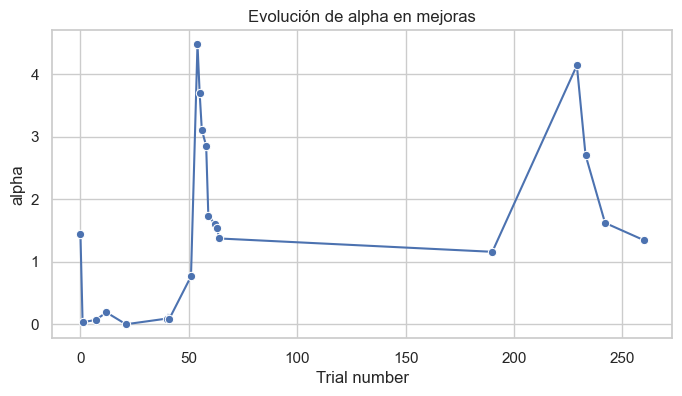

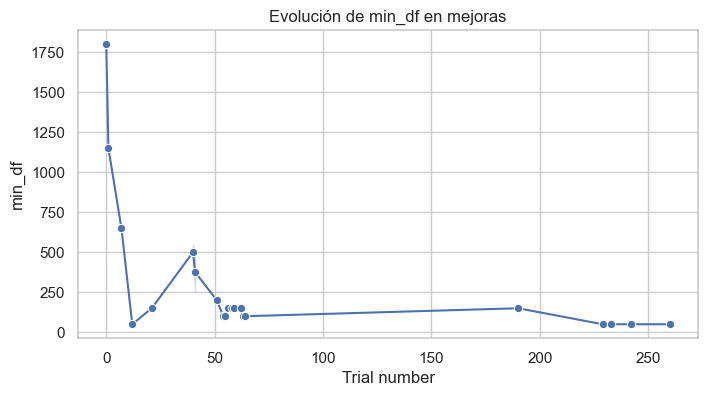

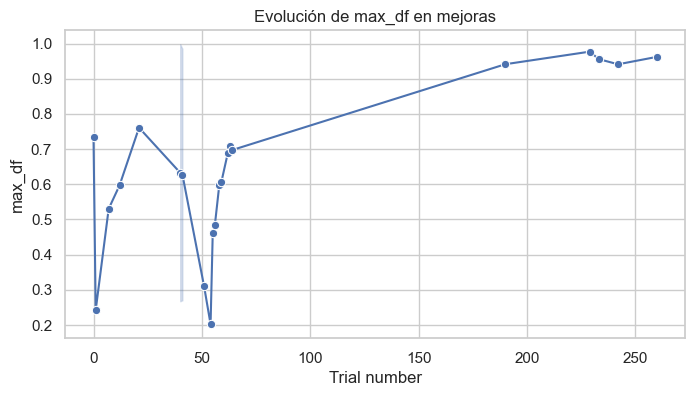

In [29]:
param_numericos = ['alpha', 'min_df', 'max_df']

for param in param_numericos:
    plt.figure(figsize=(8,4))
    sns.lineplot(data=mejoras_df, x='trial_number', y=param, marker='o')
    plt.title(f'Evolución de {param} en mejoras')
    plt.xlabel('Trial number')
    plt.ylabel(param)
    plt.grid(True)
    plt.show()

## Pedro Delgado Fin

Hemos aprendido a usar Optuna en este proyecto de Naive Bayes.